# Sampling and Monte Carlo integration

Uniform random number generators can be used to sample other probability models.
This worksheet will cover two techniques to transform a uniform random variate to a desired probability distribution:   the inverse CDF and the accept/reject method.

Random variates, uniform or not, are also a critical element of Monte Carlo (MC) integration techniques.  This worksheet will also cover this topic.

Excellent background and practical material can be in the following references:
* Devroye, Luc 1986 Non-Uniform Random Variate Generation [https://numerical.recipes/devroye/]
* Gentle, James 2003 Random Number Generation and Monte Carlo Methods
* Lepage, G.P. 1978, A New Algorithm for Adaptive Multidimensional Integration, Journal of Computational Physics, vol. 27, pp. 192-203
* Lepage, G.P. 1980, VEGAS: An Adaptive Multidimensional Integration Program, Publication CLNS-80/447, Cornell University
* Numerical Recipes Software 2007, [Complete VEGAS Code Listing](http://numerical.recipes/webnotes?9), Numerical Recipes Webnote No. 9
* Press, W.H., and Farrar, G.R. 1990, Recursive Stratified Sampling for Multidimensional Monte Carlo Integration, Computers in Physics, vol. 4, pp. 190-195

## Requirements

We import both `numpy` and `scipy`.  Both have random number engines and integration routines. 

In [1]:
import numpy as np
import scipy as sp

## Sampling:  inverse CDF method

The CDF (or cumulative distribution function) is an integral (sum) over a continuous (discrete) probability distribution function.  For this worksheet, we consider continuous distributions.  We believe that all you need to know about discrete distributions can be inferred from your knowledge of continuous ones.

The CDF has some nice properties.   First, it ranges from 0 to 1 -- the same range as our uniform random variates.   Second, it always increases from left to right.

Consider a properly normalized probability distribution $p(x)$ with CDF $P(x)$ and inverse
$P^{-1}(x)$.
The iCDF method is to solve the equation $$u = P(x)$$ or $$x = P^{-1}(u)$$ for uniform random variate $u$.
This works because:

prob($P^{-1}(u) \le x$) = prob($u \le P(x)$) = $P(x)$ and

prob($P(x) \le u$) = prob($x \le P^{-1}(u)$) = $P( P^{-1}(u) )$ = $u$.

In practice, this method is useful only for a subset of interesting probability distributions.
In other cases, one might need to solve $u = P(x)$ using numerical methods.

Here is a selection of some probability distributions that can be sampled using the iCDF method:

## Some useful probability distributions evaluated using iCDF method

| Name | Range | Density $f(x)$ | $F(X)$ | $X=F^{-1}(U)$ |
| --- |  --- |  --- | --- | --- |
| Exponential | $x\ge 0$ | $\lambda \exp(-\lambda x)$ | $1-\exp(-\lambda x)$ | $-\frac{1}{\lambda}\ln U$ |
| Cauchy | $-\infty < x < \infty$ | $\displaystyle\frac{\sigma}{\pi(x^2+\sigma^2)}$ | $\displaystyle\frac{1}{2}+\frac{1}{\pi}\arctan(\frac{x}{\sigma})$ | $\sigma \tan(\pi U)$ |
| Triangular | $0\le x\le a$ | $\displaystyle \frac{2}{a}(1-\frac{x}{a})$ | $\displaystyle \frac{2}{a}(x-\frac{x^2}{2a})$ |  $a(1-\sqrt{U})$ |

Note, use has been made of the fact that, if $U$ is a uniform random variate distribution on $(0,1)$, then so is $1-U$.

Exercise:  derive a sampling method for the triangular distribution and implement your own code to use the iCDF method.  Demonstrate that it produces the correct distribution.  (Note, you will use this case later).

## Sampling:  Accept/Reject

The iCDF method uses one random variate to generate another.   If we are willing to give up on this simple relation, we will find that we have much more flexibility to sample probability distributions.   To sample from a probability distribution $f(x)$, what is needed is a uniform random variate $u$ and a generator of another probability distribution $g(x)$ such that $f(x) < c g(x)$, where c is a constant.   $g(x)$ could be generated using any method, such as the iCDF method above.   The only challenge is to find a good function $g(x)$, which comes down to knowing something about $\sup_x f(x)$.   Assume you know the actual maximum of $f(x) \equiv f^*$.    Then, a simple (but possibly inefficient) algorithm is to select one uniform random variate to sample $x = x_\min + (x_\max - x_\min) u_1$, then accept if $\displaystyle u_2 < \frac{f(x)}{f^*}$.   The "trial" function in this case is $f^*$.

There are proofs of the basic accept/reject algorithm, but a convincing alternative is to draw a cartoon of the process and contemplate what is happening.   The algorithm samples uniformly over $(x,f(x))$ and uses the fact that the area under the curve is the integral of the function.

In the plot below, the blue curve represents our function $f(x)$ with a maximum at $x=0$.
The blue dots are random evaluations of $f(x)$ that are then compared to a uniform random variate, marked red or green depending upon whether the value of $x$ is accepted.   

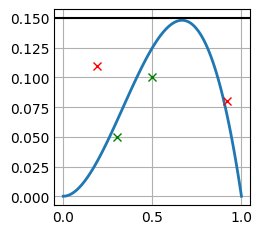

In [2]:
import matplotlib.pyplot as plt

plt.style.use('_mpl-gallery')

# make data
x = np.linspace(0, 1, 100)
y = np.power(x,2) * (1-x)

xp = np.array([0.19,0.3,0.5,0.92])
yp = np.power(x,2) * (1-x)

# plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)
ax.axhline(y=0.15,color="black")
#ax.stem(xp,yp)
ax.plot(xp[0],0.11,'x',color="red")
ax.plot(xp[1],0.05,'x',color="green")
ax.plot(xp[2],0.10,'x',color="green")
ax.plot(xp[3],0.08,'x',color="red")

plt.show()

### Majorizing

For the example function, $x^2 (1-x)$ or B(3,2) (up to a normalization), the choice of a constant overestimate leads to a large inefficiency.   Roughly $1 over 2$ of the trial choices are rejected.   The algorithm would be improved if a trial function could be selected that is easy to sample but closer to the actual function of interest.   Thus, sampling relies on function approximation.  For this case, there are two lines that can be chosen that are always larger than the function of interest.  The combination of these lines "majorizes" $f(x)$.   Your exercise is to determine this majorizing function.   

To demonstrate the method for B(3,2), we will find the line that goes through the x-axis at $x=0$.   The remainder of the exercise will be to find the line through $x=1$ and fully develop the selection algorithm.

First, it is useful to know the mode of B(a,b).   This can be derived or looked up in a reference.  The mode is found by calculating the first derivative.

Mode $=$ $a-1 \over a+b-2$.

A line through the origin has the functional from $y=m x$.   The optimal majorizing line will equal $f(x)$ at some point and, hence, have the same slope.   Solving this for a general B(a,b) yields the solution $x= {a-2 \over a+b-3}$, or $1\over 2$ (which might be obvious from the plot).   Thus, $y = m {1\over 2} = {1\over 2}^2 (1-{1\over 2}) = {1\over 8}$.   
$y = {1\over 4}x$ is the majorizing function to the left of the mode at $2 \over 3$.

The remainder of the exercise is to find the majorizing function to the right and match it to the majorizing function on the left.   

Hint 1: you must guarantee that the function on the right is always larger than B(3,2).
Hint 2: you can construct a CDF combining two triangle functions (see above) and use the iCDF method.

In [56]:
# Solution:
# 
# iCDF:  if u < 4/5, x = sqrt(4/5 u)
#        if u > 4/5, x = 1 - sqrt(1 - (u+4)/5)
# rejection:  
#        if x < 4/5, y = 1/4 x vs x^2 (1-x)
#        if x > 4/5, y = 1-x   vs x^2 (1-x)
# (check this)

Note, this algorithm can be improved by including a squeezing function.  A squeezing function bounds $f(x)$ from below.  This seems mostly to be of interest when it is expensive to evaluate $f(x)$.

## Integration

Random variates can also be the basis for performing numerical integration.    In some cases, these methods, called Monte Carlo (MC) methods, can also be used to sample probability distributions.   The starting point is the fundamental theorem of calculus.

Mean Value Theorem of Calculus

$$ I = \int_{x_{\min}}^{x_{\max}} dx  f(x) = (x_\max - x_\min) \langle f \rangle $$

The integral $I$ of a function $f(x)$ can be estimated by taking random evaluations of $f(x)$ and averaging.   For simplicity, we take the range of integration to be $(0,1)$.

$$ I = \langle f \rangle = {1\over N} \sum_{i=1}^N f(x_i)$$

Exercise:  Estimate the integral over the range (0,1):
$$
f(x) = 1/(1 + \sinh[2x]*(\ln[x])^2)
$$
(*Compare with real answer*)

Compare to trapezoidal rule.
See:  https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapezoid.html

In [68]:
from scipy import integrate
x = np.linspace(1e-12, 1.0, num=50)
y = 1 + np.sinh(2*x)*np.log(x)**2
y = 1./y
result = integrate.trapezoid(y, x)
print("trapezoidal result = ",result)

trapezoidal result =  0.6924270485357307


The sampling of the integration variable $x$ need not be uniform, and can be optimized to capture certain features of the actual function $f(x)$.    

Introduce Variance and show this is minimized by a $g(x) \propto f(x)$.
Simple example.  Compare to Gaussian quadrature.

The sampling of the integration variable $x$ need not be uniform, and can be optimized to capture certain features of the actual function $f(x)$.    This is because the choice of integration variable can be viewed as a change of coordinates in the integration variable, i.e.:

$$
\displaystyle I = \int dx g(x) {f(x) \over g(x) } = {1 \over N }\sum_{i=1}^N {f(x_i) \over g(x_i)}\bigg\vert_{x_i\sim g}
$$

What hasn't been discussed so far is the expected uncertainty in the integral estimate,
$$
\sqrt{\bigg\langle {f^2 \over g^2} \bigg\rangle - {\bigg\langle {f\over g} \bigg\rangle}^2} / \sqrt{N}.
$$
Choosing $g \sim f$ will reduce the variance.   If one could find $g(x) \propto f(x)$ and sample from it, then the variance would be $0$, but then the integral could be done analytically.

Exercise:  find a $g(x)$ to improve the MC integration and demonstrate the reduction in variance.

Finding a custom $g(x)$ to reduce the variance yields a better result from the MC algorithm, but it is much easier (and accurate) to estimate the 1-d integral using a method like the trapezoid rule.   For multi-dimensional integrals, the MC method may be the only practical method to accurately estimate an integral.   Include a timed example of quadrature vs MC methods as a function of dimensions.

## Importance and Stratified Sampling

Advanced techniques for performing MC integration rely on adapting some part of the algorithm and continuing until some criteria are satisfied.   Several good, general purpose tools exist, are readily available, and have good documentation and support.

However, it is worthwhile to discuss the algorithms for those cases when you need to do something out of the ordinary.
These algorithms adapt the sampling of the random variates based on these principle:   the integrand should be sampled where it is the largest, and the integrand should be sampled more where it is know less accurately.   The first principle leads to Importance Sampling, the second to Stratified Sampling.

This workbook concentrates on Importance Sampling.   Importance Sampling is related to the change of variable technique.
As shown, sampling according to $g(x) \propto f(x)$ reduces the variance, but it also means we have "flattened" the integration to be almost uniform in the new random variate.   For non-trivial cases, the problem is how to find such a $g(x)$ that is also invertible and efficiently sampled.    Also, the method should be generic, i.e. the user should not have to optimize a function on their own
(though intelligently choices can be made for the integration variables before attemping any numerical techniques if one has any information about the rough behavior of the integrand).

Take $g(x)$ equal to a sum of hat functions of equal area.
Evaluate over $f(x)$ in one batch and find regions where $f(x)$ is largest.   Increase the weight of those hat functions and iterate over several batches.  This is the core idea behind Vegas.   





In [10]:
def rebin(rc,r,xi):
    dr=0
    k=-1
    xn=0
    nd=len(r)
    xin=np.zeros_like(xi)
    for i in range(0,nd-1):
        while rc > dr and k < nd-1:
            k = k+1
            dr = dr + r[k]
            xo = xn
            xn = xi[k]
        dr = dr - rc
        xin[i] = xn - (xn-xo)*dr/r[k]
    xin[-1]=1.0
    return xin

In [11]:
def integrate_mc(f,xout,Nin,Min):
    y  = np.zeros(Nin)
    ys = np.zeros(Nin)
    NM = Nin*Min
    r = np.random.rand(NM,1)
    rN = r*Nin
    ibin = rN.astype(int)
    rp = rN - ibin
    dl = np.zeros_like(xout)
    dl[1:]=xout[0:-1]
    xdiff = np.diff(xout,prepend=0)

    for i,ibb in enumerate(ibin):
        ib = int(ibb)
        #if i < 10: print(i,ib,r[i],rp[i])
        #dx = xout[ib]
        #dl = 0.0
        #if ib > 0: dl = xout[ib-1]
        x = dl[ib] + xdiff[ib]*rp[i]
        fs = f(x)*xdiff[ib]*Nin
        y[ib] += fs
        ys[ib] += fs*fs
    return y/NM,ys/NM

In [63]:
# One needs an integrand:
def func(x):
    return x*(1-x)

In [25]:
# Parameters for the adaptive method
K=10
N=1000
M=500

In [26]:
np.random.seed(1234)
xdim,step = np.linspace(0.0,1.0,num=N+1,retstep=True)
xout = xdim[1:]
feval = np.zeros(K+1)
ferr  = np.zeros(K+1)
for k in range(0,K):
    ydim,ydim2  = integrate_mc(func,xout,N,M)
    ftmp  = np.sum(ydim)
    fetmp = np.sum(ydim2)
    feval[k]=ftmp
    ferr[k]=(N*M-1)/(fetmp-ftmp*ftmp)
    cdf   = np.sum(ydim)/N
    xout  = rebin(cdf,ydim,xout)
    ydim_old = ydim
#    
ydim,ydim2 = integrate_mc(func,xout,N,M)
ftmp  = np.sum(ydim)
fetmp = np.sum(ydim2)
feval[K]=ftmp
ferr[K] =(N*M-1)/(fetmp-ftmp*ftmp)
print(feval,1./ferr)
std = np.sum(ferr)
ave = np.sum(feval*ferr)
chi2 = np.sum( (feval-ave/std)**2*ferr )
print(ave/std," ",1./np.sqrt(std)*ave/std," ",chi2)

/var/folders/p4/wl536gtd6nldhtfpx68j4xrh0000gp/T/ipykernel_89555/1173027056.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ib = int(ibb)
/var/folders/p4/wl536gtd6nldhtfpx68j4xrh0000gp/T/ipykernel_89555/1173027056.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[ib] += fs
/var/folders/p4/wl536gtd6nldhtfpx68j4xrh0000gp/T/ipykernel_89555/1173027056.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ys[ib] += fs*fs


[0.16676779 0.16667483 0.16667035 0.16666303 0.16666339 0.1666753
 0.16667598 0.16667458 0.16667988 0.16665122 0.16667388] [1.11157720e-08 1.15192916e-10 9.68799129e-11 1.11688078e-10
 1.09399954e-10 1.07423156e-10 1.21653479e-10 1.03154746e-10
 1.18643247e-10 1.14269114e-10 1.06050988e-10]
0.166670328095083   5.524462424843131e-07   6.698717666781361   0.6931471805599453


In [39]:
from vegas import Integrator
import vegas

In [40]:
integ = Integrator([[0,1]])
result = integ(func,nitn=5,neval=1000)
result.summary()

'itn   integral        wgt average     chi2/dof        Q\n-------------------------------------------------------\n  1   0.166701(42)    0.166701(42)        0.00     1.00\n  2   0.166625(44)    0.166665(30)        1.61     0.20\n  3   0.166674(51)    0.166667(26)        0.82     0.44\n  4   0.166790(55)    0.166690(24)        1.89     0.13\n  5   0.166633(63)    0.166683(22)        1.60     0.17\n'

In [99]:
m = vegas.AdaptiveMap([[0,1]],ninc=9.)
integ = vegas.Integrator(m)
ny=1000
y=np.random.uniform(0.,1.,(ny,1))
x=np.empty(y.shape,float)
jac=np.empty(y.shape[0],float)
f2=np.empty(y.shape[0],float)

In [100]:
print(m.settings())

    grid[ 0] = [0.    0.111 0.222 0.333 0.444 0.556 0.667 0.778 0.889
                1.   ]



/var/folders/p4/wl536gtd6nldhtfpx68j4xrh0000gp/T/ipykernel_89555/186424577.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f2[j] = (jac[j] * func(x[j])) ** 2


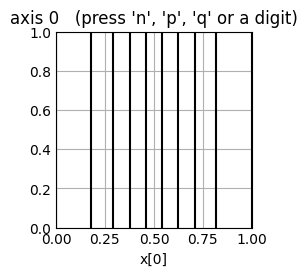

iteration 0:
    grid[ 0] = [0.    0.18  0.291 0.38  0.461 0.539 0.621 0.71  0.819
                1.   ]



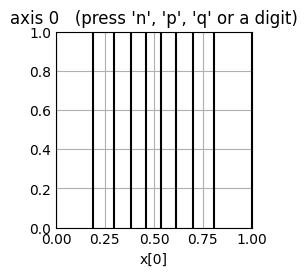

iteration 1:
    grid[ 0] = [0.    0.19  0.297 0.382 0.461 0.536 0.615 0.7   0.805
                1.   ]



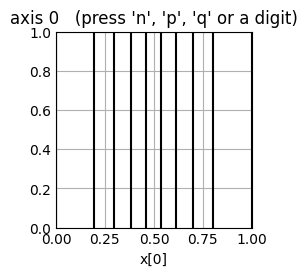

iteration 2:
    grid[ 0] = [0.    0.192 0.297 0.382 0.46  0.536 0.614 0.698 0.801
                1.   ]



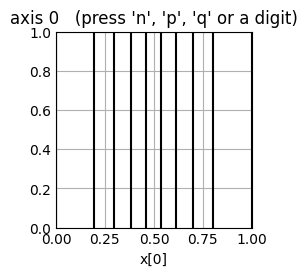

iteration 3:
    grid[ 0] = [0.    0.193 0.297 0.382 0.46  0.536 0.614 0.699 0.801
                1.   ]



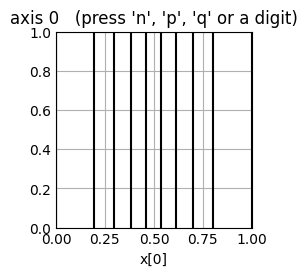

iteration 4:
    grid[ 0] = [0.    0.193 0.297 0.382 0.46  0.536 0.614 0.699 0.8
                1.   ]



'itn   integral        wgt average     chi2/dof        Q\n-------------------------------------------------------\n  1   0.166766(86)    0.166766(86)        0.00     1.00\n  2   0.166638(64)    0.166684(52)        1.41     0.24\n  3   0.166636(70)    0.166667(42)        0.86     0.42\n  4   0.166666(70)    0.166667(36)        0.57     0.63\n  5   0.166714(79)    0.166675(33)        0.50     0.73\n  6   0.166647(79)    0.166671(30)        0.42     0.83\n  7   0.166738(85)    0.166678(28)        0.45     0.85\n  8   0.166606(85)    0.166671(27)        0.48     0.85\n  9   0.166704(88)    0.166674(26)        0.43     0.90\n 10   0.166432(89)    0.166655(25)        1.14     0.33\n'

In [101]:
for itn in range(5):
    m.map(y, x, jac)
    for j in range(ny):                  # compute training data
        f2[j] = (jac[j] * func(x[j])) ** 2

    m.add_training_data(y, f2)           # adapt
    m.adapt(alpha=1.5)
    m.show_grid()

    print('iteration %d:' % itn)
    print(m.settings())    
integ=vegas.Integrator(m)
r = integ(func, neval=1e3)
r.summary()

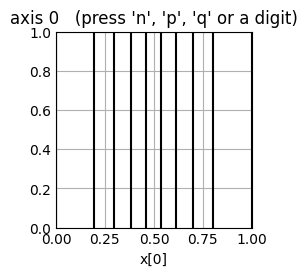

In [102]:
m.show_grid()